In [1]:
import sys

In [2]:
sys.path.append("../app/")

In [3]:
import numpy as np
import cv2
from faster_rcnn_wrapper import FasterRCNNSlim
import tensorflow as tf
import argparse
import os
import json
import time
from nms_wrapper import NMSType, NMSWrapper

import matplotlib.pyplot as plt
%matplotlib inline

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
print(tf.__version__)

1.15.2


In [5]:
class AnimeFaceDetection:
    """
    顔検知を行うためのクラス
    """
    
    def __init__(self):        
        cfg = tf.ConfigProto()
        cfg.gpu_options.allow_growth = True
        sess = tf.Session(config=cfg)
        self.sess = sess

        net = FasterRCNNSlim()
        saver = tf.train.Saver()
        saver.restore(sess, "../model/res101_faster_rcnn_iter_60000.ckpt")
        self.net = net
    
    def detect(self, image):
        # pre-processing image for Faster-RCNN
        img_origin = image.astype(np.float32, copy=True)
        img_origin -= np.array([[[102.9801, 115.9465, 112.7717]]])
    
        img_shape = img_origin.shape
        img_size_min = np.min(img_shape[:2])
        img_size_max = np.max(img_shape[:2])
    
        img_scale = 600 / img_size_min
        if np.round(img_scale * img_size_max) > 1000:
            img_scale = 1000 / img_size_max
        img = cv2.resize(img_origin, None, None, img_scale, img_scale, cv2.INTER_LINEAR)
        img_info = np.array([img.shape[0], img.shape[1], img_scale], dtype=np.float32)
        img = np.expand_dims(img, 0)
    
        # test image
        _, scores, bbox_pred, rois = self.net.test_image(self.sess, img, img_info)
    
        # bbox transform
        boxes = rois[:, 1:] / img_scale
    
        boxes = boxes.astype(bbox_pred.dtype, copy=False)
        widths = boxes[:, 2] - boxes[:, 0] + 1
        heights = boxes[:, 3] - boxes[:, 1] + 1
        ctr_x = boxes[:, 0] + 0.5 * widths
        ctr_y = boxes[:, 1] + 0.5 * heights
        dx = bbox_pred[:, 0::4]
        dy = bbox_pred[:, 1::4]
        dw = bbox_pred[:, 2::4]
        dh = bbox_pred[:, 3::4]
        pred_ctr_x = dx * widths[:, np.newaxis] + ctr_x[:, np.newaxis]
        pred_ctr_y = dy * heights[:, np.newaxis] + ctr_y[:, np.newaxis]
        pred_w = np.exp(dw) * widths[:, np.newaxis]
        pred_h = np.exp(dh) * heights[:, np.newaxis]
        pred_boxes = np.zeros_like(bbox_pred, dtype=bbox_pred.dtype)
        pred_boxes[:, 0::4] = pred_ctr_x - 0.5 * pred_w
        pred_boxes[:, 1::4] = pred_ctr_y - 0.5 * pred_h
        pred_boxes[:, 2::4] = pred_ctr_x + 0.5 * pred_w
        pred_boxes[:, 3::4] = pred_ctr_y + 0.5 * pred_h
        # clipping edge
        pred_boxes[:, 0::4] = np.maximum(pred_boxes[:, 0::4], 0)
        pred_boxes[:, 1::4] = np.maximum(pred_boxes[:, 1::4], 0)
        pred_boxes[:, 2::4] = np.minimum(pred_boxes[:, 2::4], img_shape[1] - 1)
        pred_boxes[:, 3::4] = np.minimum(pred_boxes[:, 3::4], img_shape[0] - 1)
        return scores, pred_boxes

In [6]:
detector = AnimeFaceDetection()





Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
box_ind is deprecated, use box_indices instead
INFO:tensorflow:Restoring parameters from ../model/res101_faster_rcnn_iter_60000.ckpt


In [11]:
img = cv2.imread("../input/landscape.jpeg")

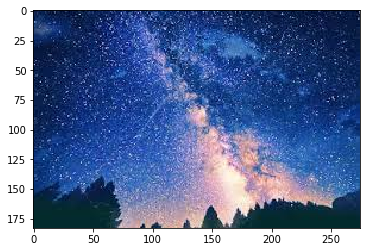

In [13]:
plot(img)

In [40]:
%%time
scores, boxes = detector.detect(img)

CPU times: user 8.92 s, sys: 406 ms, total: 9.32 s
Wall time: 4.83 s


In [29]:
nms_type = NMSType.PY_NMS
nms = NMSWrapper(nms_type)

In [30]:
nms_thresh = 0.3
conf_thresh = 0.8
crop_output_image_location = "hoge"
start_output_number = 0

In [31]:
boxes = boxes[:, 4:8]
scores = scores[:, 1]
keep = nms(np.hstack([boxes, scores[:, np.newaxis]]).astype(np.float32), nms_thresh)
boxes = boxes[keep, :]
scores = scores[keep]
inds = np.where(scores >= conf_thresh)[0]
scores = scores[inds]
boxes = boxes[inds, :]

In [34]:
len(scores)

0

In [33]:
boxes

array([], shape=(0, 4), dtype=float32)

In [35]:
boxes

array([], shape=(0, 4), dtype=float32)

In [37]:
for box in boxes:
    x1, y1, x2, y2 = box
    print("hoge")

In [59]:
def face_detection_by_frcnn(image):
    scores, boxes = detector.detect(image)
    
    nms_type = NMSType.PY_NMS
    nms = NMSWrapper(nms_type)
    nms_thresh = 0.3
    conf_thresh = 0.8
    
    boxes = boxes[:, 4:8]
    scores = scores[:, 1]
    keep = nms(np.hstack([boxes, scores[:, np.newaxis]]).astype(np.float32), nms_thresh)
    boxes = boxes[keep, :]
    scores = scores[keep]
    inds = np.where(scores >= conf_thresh)[0]
    scores = scores[inds]
    boxes = boxes[inds, :]
    
    face_images = []
    cropped_image = image.copy()
    
    for box in boxes:
        x1, y1, x2, y2 = box
        face_image = image[int(y1):int(y2), int(x1):int(x2)]
        cropped_image = cv2.rectangle(cropped_image, (x1,y2), (x2,y1), (0,255,0), 3)
        face_images.append(face_image)
    
    return face_images, cropped_image

In [60]:
image = cv2.imread("../input/newgame.jpg")

In [61]:
face_images, cropped_image = face_detection_by_frcnn(image)

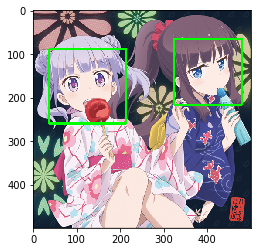

In [62]:
plot(cropped_image)

In [8]:
def plot(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.imshow(img)
    return ax

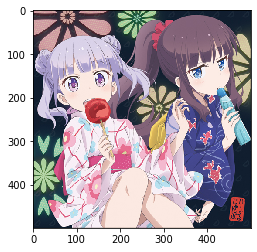

In [35]:
plot(img)

In [36]:
img.shape

(500, 500, 3)

In [45]:
x1, y1, x2, y2 = boxes[0]

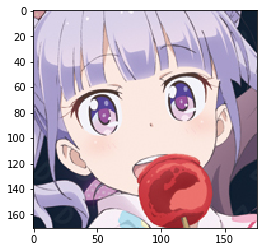

In [42]:
plot(img[int(y1):int(y2), int(x1):int(x2)])

In [ ]:
img = cv2.rectangle(img,(384,0),(510,128),(0,255,0),3)

In [46]:
# img2 = cv2.rectangle(img, (x1,y2), (x2,y1), (0,255,0), 3)
img2 = cv2.rectangle(img2, (x1,y2), (x2,y1), (0,255,0), 3)

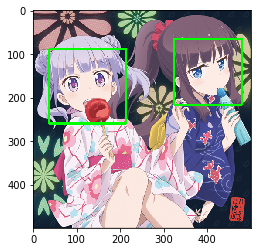

In [47]:
plot(img2)

In [ ]:
result[file] = []
for i in range(scores.shape[0]):
    x1, y1, x2, y2 = boxes[i, :].tolist()
    new_result = {'score': float(scores[i]),
                  'bbox': [x1, y1, x2, y2]}
    result[file].append(new_result)

    if args.output is None:
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)

    if args.crop_output_image_location:
        cropped_image = img[int(y1):int(y2), int(x1):int(x2)]

        if args.crop_width and args.crop_height:
            cropped_image = cv2.resize(cropped_image, 
                                      (args.crop_width, args.crop_height), 
                                      interpolation = cv2.INTER_AREA)

        cv2.imwrite(args.crop_output_image_location + str(args.start_output_number) + ".jpg", cropped_image)
        args.start_output_number += 1